In [ ]:
#!pip install matplotlib-label-lines

In [1]:
import platform 
import os, time
# dictionary 
info = {} 
  
platform_details = platform.platform() 
info["platform details"] = platform_details 
system_name = platform.system() 
info["system name"] = system_name 
processor_name = platform.processor() 
info["processor name"] = processor_name 
architecture_details = platform.architecture() 
info["architectural detail"] = architecture_details 
for i, j in info.items(): 
    print(i, " - ", j) 

print(os.getcwd())

platform details  -  Windows-10-10.0.19041-SP0
system name  -  Windows
processor name  -  Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
architectural detail  -  ('64bit', 'WindowsPE')
C:\Users\sd\notebooks\MAIN_PRJWindows\AddConstToObj


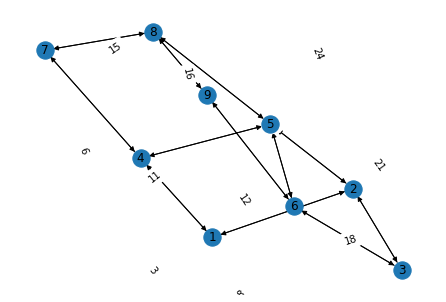

In [2]:
from datetime import datetime
import networkx as nx
import sqlite3 
import os
import sys
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
from labellines import labelLines

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sdNetworkUtility  import *
from sdTapPyomo  import *
from sdLIPSolverAddConstToObj  import *
#----------------------------------
np. set_printoptions(threshold=np. inf)


#در ساختار شبکه در جدول نودها فرض شده که نودهایی که می توانند مبدا یا مقصد یک زوج مبدا مقصد باشند(زون هستند)در همان ابندای جدول و از اندیس
#1 - n
#آمده اند و فیلد 
#is_OD 
#آنها 1 است
# Create a SQL connection to our SQLite database               # 9Nodes  SiouxFalls Anaheim
con = sqlite3.connect("C:/Users/sd/notebooks/MAIN_PRJWindows/TraficAssignment/1_project/9Nodes/project_database.sqlite")
cur = con.cursor()
G = nx.DiGraph()
#مشخص کردن تعداد ODها
cur.execute('SELECT count(is_OD) FROM nodes where is_OD = 1 ')
Data= cur.fetchall()
NodeODCount =Data[0][0] #تعداد نودهایی که مبدا یا مقصد هستند(زون هستند) 
ODCount = NodeODCount**2
#-------------
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data: #---We use free_flow_time As weight of edges for compute K-Shortest path
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
#----------رسم گراف شبکه----

sdDrawGraph(nx,G)

ODNumber_Matrix = sdGet_ODNumber_Matrix(NodeODCount)
n,m = np.shape(ODNumber_Matrix)

# تقاضا بین زوجها
ODDeman_Matrix = pd.read_excel(r'C:/Users/sd/notebooks/MAIN_PRJWindows/TraficAssignment/0_tntp_data/9Nodes/xod.xlsx',sheet_name='Sheet1')
ODDeman_Vector = np.zeros(ODCount) 
for i in range(n):
     for j in range(m):
        ODDeman_Vector[ODNumber_Matrix[i,j] - 1] = ODDeman_Matrix.iloc[i,j]

#--تعریف ساختمان داده های لازم
#لیست تمام یالهای گراف را میدهد اما نامرتب
edgs = list(G.edges(data=True))

#مرتب کردن یالها بر اساس شماره لینک
LinksList =  list(np.zeros(len(edgs)))
for row in edgs:
    LinksList[row[2]['link_id'] -1] = row
 
 
#فقط برای نودهای مبدا-مقصد که در اول لیست نودها هم هستند کوتاهترین مسیرها محاسبه می شود
All_KshortestPathList = sdGetAll_KshortestPath(nx,G,3,NodeODCount)

        #ماتریس تعیین عضویت هر زوج در هر مسیر
DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 
        #ماتریس تعیین عضویت هر لینک در هر مسیر
DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)

#P_i: set of paths between origin-destination in I
LinkCount = len(LinksList) 
PathCount = len(All_KshortestPathList )

LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]

LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]
        



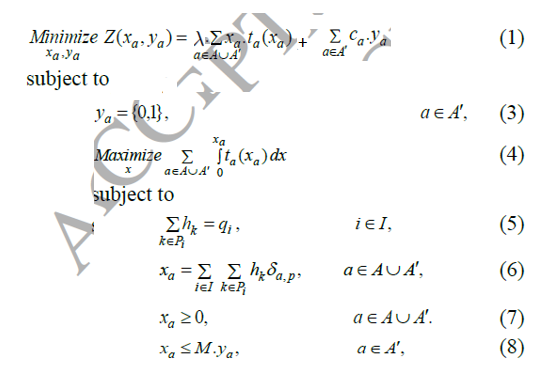

In [3]:
#--Calculate High Level Objective Function
# free Flow Time به دقیقه
#زمان سفر کل بر حسب دقیقه در روز
#ظرفیت  بر حسب تعداد خودرو در روز
#جریان  بر حسب تعداد خودرو در روز
# تعداد خودرو در روز تقاضای سفر بر حسب

def CalcZ(intObjectiveFunc,X,Capacity,Tzero,Cost,linksY, Min1=0,Max1=0,Min2 = 0,Max2=0, Landa= 1):
    #ایران
    #GDP = 2282 * 280000  #ریال
    #TW = 365 * 8
    #VOT = GDP / TW  ارزش یک ساعت کار
   #------------------
    #آمریکا
    GDP = 63543  #دلار
    TW = 365 * 5 # 
    VOT = GDP / TW  #  ارزش یک ساعت کار
    VOT = VOT / 60 #ارزش یک دقیقه کار
    if intObjectiveFunc == 1: #فقط هزینه زمان سفر کل
        return VOT * sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) )
    elif intObjectiveFunc == 2: #فقط هزینه ساخت
        return sum(Cost[z] * linksY[z] for z in range(len(Cost)))
    elif intObjectiveFunc == 3: #  در رنج 1 هر دو
        C1 = Max1 - Min1
        C2 = Max2 - Min2
        return ( Landa * (((sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) ) ) - Min1) /C1)  + ( (sum(Cost[z] * linksY[z] for z in range(len(Cost))) - Min2) / C2) )  
    elif intObjectiveFunc == 4: # هر دو
        return ( Landa * VOT * (((sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) ) ) ))  + ( (sum(Cost[z] * linksY[z] for z in range(len(Cost))) ) ) )  
    

In [4]:
def CalcZBar(linksY,Ba):
    return sum(linksY[z] * Ba[z] for z in range(len(linksY)))
 

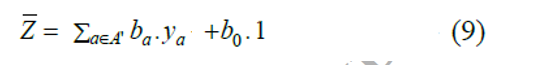

In [5]:
PrgStartTime = datetime.now()
print('Program Satrt Time: '+ PrgStartTime.strftime('%X'))

TedadTekrar = 20

Landa = 12

TAPRuningTimeAll = []
LinearRegressionRuningTimeAll = []
LIPRuningTimeAll = []
Zbar_Matrix = []
#Anaheim
#NewLinkIds = np.array([636,719, 771,718 ,665,699, 414,451, 428,483])
#NewLinkCost = np.array([44 * 10**9, 59 * 10**9, 79 * 10**9, 86 * 10**9, 58 * 10**9,44 * 10**9, 59 * 10**9, 79 * 10**9, 86 * 10**9, 58 * 10**9])

#SiouxFalls
#NewLinkIds = np.array([1,3, 12,15 ,33,36, 47])#,46, 50,55])
#NewLinkCost = np.array([2.4 * 10**6, 2.4 * 10**6, 2.1 * 10**6, 2.1 * 10**6, 2.2 * 10**6,2.2 * 10**6, 1.9 * 10**6])#, 1.9 * 10**6, 1.8 * 10**6, 1.8 * 10**6])

#9Nodes
NewLinkIds = np.array([4,6,9,12,14,20]) 
NewLinkCost = np.array([8 * 10**3, 4 * 10**3,9 * 10**3,7 * 10**3,6 * 10**3,6.5 * 10**3])

#---ابتدا با در با فرض اینکه تمام لینکها احداث شده اند و تابع هدف سطح بالا فقط عبارت اول که همان زمان سفر کل است را دارد،جریانها و زمان سفر کل را حساب می کنیم تا مقدار مینیمم زمان سفر نهایی را حساب کنیم
#-- از این مقدار و مقدار ماکزیمم زمان سفر نهایی که بعدا محاسبه می کنیم برای نرمال کردن عبارت زمان سفر نهایی در تابع هدف دو عبارتیمان استفاده میکنیم
###############محاسبه مقدار مینیمم زمان سفر کل###########################
# گرافی می سازیم که شامل تمام لینکهای جدید هم می شود و  از  همان اطلاعات برای محاسبه مقدار مینیمم زمان سفر کل استفاده میکنیم
# ساخت مجدد شبکه و اطلاعات لازم
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data:
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
LinksList = list(G.edges(data=True))
All_KshortestPathList = sdGetAll_KshortestPath(nx,G,3,NodeODCount)
DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 

        #ماتریس تعیین عضویت هر لینک در هر مسیر
DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)
LinkCount = len(LinksList) 
PathCount = len(All_KshortestPathList )
LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]
LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]

ytmp =  np.array([[1] * len(NewLinkIds)])    
#flows = sdSolveTapByPyomo(PathCount,LinkCount,ODCount,DeltaOD_Matrix,DeltaLink_Matrix,ODDeman_Vector,LinkFreeFlowTime_Vector,LinkCap_Vector)
####Minimum of TotalTravelTime Occured when all y are 1
#MinTotalTravelTime = CalcZ(1,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,ytmp[0][:len(ytmp[0])]) 
#MaxCostForNewLinks = CalcZ(2,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,ytmp[0][:len(ytmp[0])]) 
#print('MinTotalTravelTime = ', MinTotalTravelTime)

########################################

#حذف لینکهای جدید از شبکه برای آماده کردن شبکه
strLinksForRemove = '-1'
for lkid in NewLinkIds:
    strLinksForRemove = strLinksForRemove + ',' + str(lkid)
#---دور اول ---
y =  np.array([[0] * len(NewLinkIds)])#انداره y  لینکهای جدید به تعداد
    
# ساخت مجدد شبکه و اطلاعات لازم
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links where link_id not in ('+ strLinksForRemove + ' ) order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data:
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
LinksList = list(G.edges(data=True))
All_KshortestPathList = sdGetAll_KshortestPath(nx,G,3,NodeODCount)
DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 
        #ماتریس تعیین عضویت هر لینک در هر مسیر
DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)


LinkCount = len(LinksList) 
PathCount = len(All_KshortestPathList )
#total flow on the path k in P_ij = _fijk         جریان در کاامین مسیر از زوج آی و جی

LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]

LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]
#-------------------------------
   
#sdDrawGraph(nx,G)

#---Solve TAP and calculate flows---
flows = sdSolveTapByPyomo(PathCount,LinkCount,ODCount,DeltaOD_Matrix,DeltaLink_Matrix,ODDeman_Vector,LinkFreeFlowTime_Vector,LinkCap_Vector)
#print('flows',flows)

#Maximum of TotalTravelTime Occured when all y are 0
#MaxTotalTravelTime = CalcZ(1,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])]) 
#MinCostForNewLinks = CalcZ(2,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])]) 

#print('MaxTotalTravelTime = ', MaxTotalTravelTime)
print('y = ',y)
#z1 = CalcZ(1,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])])
#z2 = CalcZ(2,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])])
#print("z1 = ",z1)
#print("z2 = ",z2)

#---Calculate z base on flows---
z = CalcZ(4,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])],0,0
          ,0,0, Landa)
#--چون تمام لینکها صفر هستند پس مقدار زدبار صفر می شود
Zbar = 0
Zbar_Matrix.append(Zbar)

print('z',z)
# ---Adding Curent z To Z vector---
Z = np.array( [z])
#print('Z',Z)

#========REGRESSION===========

#--اگر بخواهیم در تابع خطی و رگرسیون جمله مربوط به هزینه ها باشد باید این قسمت کد برای محاسبه
#B_bar
#فعال شود
#---Cailculate B_bar multiple-------
c = NewLinkCost 
#T = 0
#for i in range(len(y[0])):
#    T += c[i]*y[0][i]
#--Adding Current y To Y Matrix

#Y= np.array([np.append(y,T)])
Y= np.array(y)
X_train = Y
Y_train = Z
print('Y = ',Y)

#print('X_train',X_train)
#print('Y_train',Y_train)

model = LinearRegression()
model.fit(X_train, Y_train)

ModelCoef = np.array([model.coef_])

print('model.coef_, intercept_',model.coef_,model.intercept_)
#print('ModelCoef',ModelCoef)

b=model.coef_[0:len(NewLinkIds)]
#print('b',b)

#B_bar = model.coef_[len(NewLinkIds)]
Last_y = y[0]
#print('Param: ',c, b,Last_y )

#y = sdLIPSolve(c,b,B_bar,Y,'glpk')
y = sdLIPSolve(c,b,Y,'glpk')

MainloopStartTime = datetime.now()

print('MainLoop Satrt Time: '+ MainloopStartTime.strftime('%X'))
#---حلقه اصلی برنامه----

for Idx in range(TedadTekrar):#Main Loop
        print('====================================== ')
        print('شماره تکرار = ', Idx +1 )
        print('y = ',y )
        #---Create Network Base  On current y---
        strLinksForRemove = '-1'
        for i in range(len(y[0])):
            if y[0][i] == 0:
                strLinksForRemove = strLinksForRemove + ',' + str(NewLinkIds[i])
                
        #DrawNetwork(prj)
       #---ساخت مجدد شبکه با اعمال تغییرات لینکها 
        cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links where link_id not in ('+ strLinksForRemove + ' ) order by link_id ')
        Data= cur.fetchall()
        G.clear()
        for row in Data:
            G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
        LinksList = list(G.edges(data=True))
        All_KshortestPathList = sdGetAll_KshortestPath(nx,G,3,NodeODCount)
        DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 
                #ماتریس تعیین عضویت هر لینک در هر مسیر
        DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)

        #P_i: set of paths between origin-destination in I
        LinkCount = len(LinksList) 
        PathCount = len(All_KshortestPathList )
       

        LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]

        LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]
        #-------------------------------
        
        #---Solve TAP and calculate flows---
        TAPStartTime = datetime.now()
        flows = sdSolveTapByPyomo(PathCount,LinkCount,ODCount,DeltaOD_Matrix,DeltaLink_Matrix,ODDeman_Vector,LinkFreeFlowTime_Vector,LinkCap_Vector)
        #print('flows',flows)
        TAPFinishTime = datetime.now()
        print('TAPRuningTime: ', TAPFinishTime - TAPStartTime)  
        TAPRuningTimeAll.append((TAPFinishTime - TAPStartTime).total_seconds())
        #---Calculate z base on flows---

        #z1 = CalcZ(1,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])])
        #z2 = CalcZ(2,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])])
        #print("z1 = ",z1)
        #print("z2 = ",z2)

        
        z = CalcZ(4,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])],0,0
                  ,0,0, Landa )
        # ---Adding Curent z To Z vector---
        Z = np.append(Z,[z], axis = 0) 

        #========REGRESSION===========
        
        Y_train = Z
        c = NewLinkCost 

    #--اگر بخواهیم در تابع خطی و رگرسیون جمله مربوط به هزینه ها باشد باید این قسمت کد برای محاسبه
    #B_bar
    #فعال شود
    #---Cailculate B_bar multiple-------
        #T = 0
        #for i in range(len(y[0]) ):
        #    T += c[i]*y[0][i]
        #--Adding Current y To Y Matrix
        #Y= np.append(Y, [np.append(y,T)], axis = 0)
        Y= np.append(Y, y, axis = 0)
        ModelCoef = np.append(ModelCoef, [model.coef_], axis = 0)

        #print("Y", Y)

        X_train = Y 
        
        #print('X_train',X_train)
       # print('Y_train',Y_train)
        LinearRegressionStartTime = datetime.now()
        model = LinearRegression()
        model.fit(X_train, Y_train)
        LinearRegressionFinishTime = datetime.now()
        print('LinearRegressionRuningTime: ', LinearRegressionFinishTime - LinearRegressionStartTime)  
        LinearRegressionRuningTimeAll.append((LinearRegressionFinishTime - LinearRegressionStartTime).total_seconds())
        
        print('model.coef_',model.coef_)
      #  print('ModelCoef',ModelCoef)

        b=model.coef_[:len(NewLinkIds)]

        Zbar = CalcZBar(y[0],b)
        Zbar_Matrix.append(Zbar)
        
        #print('b',b)
        #B_bar = model.coef_[len(NewLinkIds)]
        Last_y = y[0]
        #y = sdLIPSolve(c,b,B_bar,Y,'glpk')
        LIPStartTime = datetime.now()
        y = sdLIPSolve(c,b,Y,'glpk')
        LIPFinishTime = datetime.now()
        print('LIPRuningTime: ', LIPFinishTime - LIPStartTime)  
        LIPRuningTimeAll.append((LIPFinishTime - LIPStartTime).total_seconds())

        #print('Param: c, b,y,z',c, b,B_bar,y,z )
        #print('c = ', c )
        print('b = ',b )
        print('z = ',z )
        print('Zbar = ',Zbar)
        #print('Y = ', Y )
        #print('Z = ', Z )
        print('****************************************************************************************')

print('********************************************')
print('********************************************')
MainloopFinishTime = datetime.now()
print('MainloopFinishTime: ', MainloopFinishTime.strftime('%X'))  
print('MainloopRuningTime: ', MainloopFinishTime - MainloopStartTime)  


PrgFinishTime = datetime.now()
print('PrgFinishTime: ', PrgFinishTime.strftime('%X'))  
print('ProgramRuningTime: ', PrgFinishTime - PrgStartTime)  


#print('MinTotalTravelTime = ', MinTotalTravelTime)
#print('MaxTotalTravelTime = ', MaxTotalTravelTime)
#print('MinCostForNewLinks = ', MinCostForNewLinks)
#print('MaxCostForNewLinks = ', MaxCostForNewLinks)
print('ModelCoef',ModelCoef)


print('Min Of Z = ',np.amin(Z), '  Where is in  ',np.where(Z == np.amin(Z)))
 
print('Max Of Z = ',np.amax(Z), '  Where is in  ',np.where(Z == np.amax(Z)))

print('Min Of Zbar_Matrix = ',np.amin(Zbar_Matrix), '  Where is in  ',np.where(Zbar_Matrix == np.amin(Zbar_Matrix)))
 
print('Max Of Zbar_Matrix = ',np.amax(Zbar_Matrix), '  Where is in  ',np.where(Zbar_Matrix == np.amax(Zbar_Matrix)))

print('Proposed Links: ', Y[np.where(Z == np.amin(Z))[0][0]][:len(NewLinkIds)])
print('NewLinkIds      ',NewLinkIds)




Program Satrt Time: 13:22:31
y =  [[0 0 0 0 0 0]]
z 434469.3157832139
Y =  [[0 0 0 0 0 0]]
model.coef_, intercept_ [0. 0. 0. 0. 0. 0.] 434469.3157832139
    solver failure.
MainLoop Satrt Time: 13:22:34
شماره تکرار =  1
y =  [array([1., 0., 0., 0., 0., 0.])]
TAPRuningTime:  0:00:03.207155
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14051.96610504      0.              0.              0.
      0.              0.        ]
LIPRuningTime:  0:00:00.071755
b =  [-14051.96610504      0.              0.              0.
      0.              0.        ]
z =  420417.3496781708
Zbar =  -14051.966105043071
****************************************************************************************
شماره تکرار =  2
y =  [array([1., 1., 0., 0., 0., 0.])]
TAPRuningTime:  0:00:03.707093
LinearRegressionRuningTime:  0:00:00
model.coef_ [-14051.96610504 -20180.13775001      0.              0.
      0.              0.        ]
LIPRuningTime:  0:00:00.074153
b =  [-14051.96610504 -20180.13775001      0.

LIPRuningTime:  0:00:00.080691
b =  [-14551.32968241 -18599.14049336  -7007.7581616  -30441.37589435
 -14920.44829803  -4562.90595503]
z =  360717.8807359585
Zbar =  -71483.81799142923
****************************************************************************************
شماره تکرار =  16
y =  [array([1., 0., 1., 1., 1., 0.])]
TAPRuningTime:  0:00:04.070904
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15056.01583212 -16931.72720809  -7314.46783389 -31602.0514602
 -15236.39003402  -3691.5017189 ]
LIPRuningTime:  0:00:00.081359
b =  [-15056.01583212 -16931.72720809  -7314.46783389 -31602.0514602
 -15236.39003402  -3691.5017189 ]
z =  361235.6193102905
Zbar =  -69208.92516023233
****************************************************************************************
شماره تکرار =  17
y =  [array([1., 0., 0., 1., 1., 1.])]
TAPRuningTime:  0:00:03.987019
LinearRegressionRuningTime:  0:00:00
model.coef_ [-15619.93448489 -15637.81438309  -6518.78156728 -32061.89612077
 -15656.37656992

Z =  [434469.31578321 420417.34967817 400237.21192816 392535.68624314
 361851.59794051 347922.22810286 347586.43621036 348232.48507757
 356855.5537874  361869.50765418 359287.4767279  359760.84663003
 363449.03900614 364001.72183285 373447.62466179 360717.88073596
 361235.61931029 361363.92958491 373587.36117455 371595.33706428
 359915.80137919]
Zbar =  -67746.75378111792
Y =  [[0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 1. 0. 1.]
 [0. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 0.]
 [0. 1. 0. 1. 1. 1.]
 [1. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 1. 0.]
 [1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 1. 1.]
 [1. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1.]]
ModelCoef =  [[     0.              0.              0.              0.
       0.              0.        ]
 [     0.              0.              0.              0.
       0.     

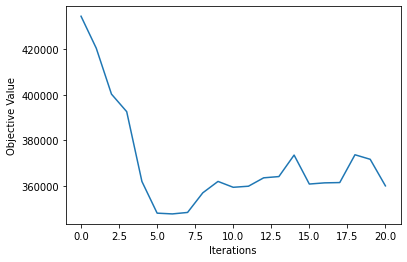

In [6]:

print('Z = ',Z)
print('====================================')
print('Zbar = ',Zbar)
print('====================================')
print('Y = ',Y)
print('====================================')
print('ModelCoef = ',ModelCoef)
print('====================================')

print('Proposed Links: ', Y[np.where(Z == np.amin(Z))[0][0]][:len(NewLinkIds)])
print('NewLinkIds      ',NewLinkIds)
plt.plot(Z)
plt.xlabel('Iterations') 
plt.ylabel('Objective Value') 
plt.show()


In [ ]:
#--رسم نمودار مقادیر z ,Zbar
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(range(len(Z)), Z, label = 'Z', linestyle="-")
plt.plot(range(len(Zbar_Matrix)), Zbar_Matrix, label = 'Zbar_Matrix', linestyle="-")
plt.xlabel('Iterations') 
plt.ylabel('Value' )
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.show()

In [ ]:
#رسم نمودارهای ضرایب لینکها در رگرسیون در تکرارهای مختلف
plt.rcParams['figure.figsize'] = [12, 8]
for i in range(i):
    plt.plot(range(len(ModelCoef[:,i])), ModelCoef[:,i], label = 'Link ' + str(i + 1), linestyle="-")
    plt.xlabel('Iterations') 
    plt.ylabel('Coefficients Of Links' )
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.show()

In [ ]:
#نمودارهای زمان اجرای قسمتهای مختلف کد
print('ProgramRuningTime: ', (PrgFinishTime - PrgStartTime).total_seconds())  

TAPRuningTimeTotal = sum(TAPRuningTimeAll)
print('TAPRuningTimeTotal = ',TAPRuningTimeTotal)

LinearRegressionRuningTimeTotal = sum(LinearRegressionRuningTimeAll)
print('LinearRegressionRuningTimeTotal = ',LinearRegressionRuningTimeTotal)

LIPRuningTimeAllTotal = sum(LIPRuningTimeAll)
print('LIPRuningTimeAllTotal = ',LIPRuningTimeAllTotal)

plt.plot(TAPRuningTimeAll)
plt.xlabel('Iterations') 
plt.ylabel('TAPRuningTimeAll') 
plt.show()

plt.plot()
plt.xlabel('Iterations') 
plt.ylabel('LinearRegressionRuningTimeAll') 
plt.show()

plt.plot(LIPRuningTimeAll)
plt.xlabel('Iterations') 
plt.ylabel('LIPRuningTimeAll') 
plt.show()
